# EEG Classification of ADHD and Control(Normal) Children

**Aim:**
In this notebook we aim to classify ADHD and normal children (binary classification task) based on EEG recordings. 


Dataset link: https://ieee-dataport.org/open-access/eeg-data-adhd-control-children <br>
Done by: Shania Job (19pd32)

#Contents 

1. Understanding and preprocessing the data
2. Visualization and Analysis of the data
3. Modelling (using in-built libraries)
4. Evaluation metrics 

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
!pip install mne

     |████████████████████████████████| 7.4 MB 28.5 MB/s 


In [ ]:
# Importing the necessary libararies
import os
import random

import mne
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.linear_model import Perceptron 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report

## Understanding and preprocessing the data

The aim of the project is to classify between ADHD children and normal children based on the EEG recordings.The entire data is sectioned into 4 parts i.e. ADHD_part1, ADHD_part2, Control_part1 and Control_part2. Each part consists of many .mat files where each .mat file corresponds to a person's EEG data. 

In [ ]:
# Walk through each directory and find out how many files are present in each subdirectory.
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

In [ ]:
walk_through_dir('/content/drive/MyDrive/EEG_data')

There are 4 directories and 2 files in '/content/drive/MyDrive/EEG_data'.
There are 0 directories and 30 files in '/content/drive/MyDrive/EEG_data/Control_part2'.
There are 0 directories and 30 files in '/content/drive/MyDrive/EEG_data/Control_part1'.
There are 0 directories and 31 files in '/content/drive/MyDrive/EEG_data/ADHD_part2'.
There are 0 directories and 30 files in '/content/drive/MyDrive/EEG_data/ADHD_part1'.


Therefore we can see there that in total there are 61 ADHD .mat files (61 ADHD children reports) and 60 normal .mat files (60 normal children reports) which are equally distributed under 2 parts.

In [ ]:
# Viewing contents of the .mat files 
def view_random_file_contents(target_dir, target_class):
  # Setup target directory 
  target_folder = target_dir + target_class

  # Get a random file path
  random_file = random.sample(os.listdir(target_folder), 1)
  
  contents = scipy.io.loadmat(target_folder + random_file[0])
  print("------------------------------")
  print("Directory: ", target_folder)
  print(contents)
  print("------------------------------")

In [ ]:
target_dir = "/content/drive/MyDrive/EEG_data/"
target_class = ["ADHD_part1/", "ADHD_part2/", "Control_part1/", "Control_part2/"]
random_contents = []
for i in range(len(target_class)):
  view_random_file_contents(target_dir=target_dir, target_class=target_class[i])

------------------------------
Directory:  /content/drive/MyDrive/EEG_data/ADHD_part1/
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Apr 12 15:32:41 2020', '__version__': '1.0', '__globals__': [], 'v31p': array([[-195, -336,   89, ...,  121, -266,  226],
       [-371, -442,  -94, ...,  -19, -336,  121],
       [-442, -407, -167, ..., -195, -407,   50],
       ...,
       [ -90,  156,   16, ...,  -55,  191,   50],
       [ -90,   85,   16, ...,   85,  191,   85],
       [  85,  121,  200, ...,  156,  121,   85]], dtype=int16)}
------------------------------
------------------------------
Directory:  /content/drive/MyDrive/EEG_data/ADHD_part2/
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Apr 12 15:32:37 2020', '__version__': '1.0', '__globals__': [], 'v213': array([[-19,  85, -20, ...,  15,  50, 156],
       [297, 121, 457, ..., 437, -55,  50],
       [297,  85, 457, ..., 297, -90, -19],
       ...,
       [297, 261, 347, ..., 297, 1

As we can see each .mat file is stored as a dictionary. Now we will look at a particular .mat file under each subdirectory. 

In [ ]:
# A random .mat file under adhd_part2 directory.
file = random.sample(os.listdir(target_dir + target_class[1]), 1)
adhd_contents = scipy.io.loadmat(target_dir + target_class[1] + file[0])
adhd_contents  

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Apr 12 15:32:37 2020',
 '__version__': '1.0',
 'v215': array([[ 191, -371,  200, ...,  226, 4802, 4802],
        [ 261,   15,  273, ...,  261,  297,  226],
        [ 261,   50,  347, ...,  297,  226,   85],
        ...,
        [ 156,  121,  163, ...,  121,   85,  226],
        [  50,  121,   89, ...,  191,   50,  261],
        [ 226,   85,  200, ...,  261,   50,  332]], dtype=int16)}

In [ ]:
print(adhd_contents['v215'])
print(f"Number of rows: {len(adhd_contents['v215'])}")
print(f"Number of columns: {len(adhd_contents['v215'][0])}")

[[ 191 -371  200 ...  226 4802 4802]
 [ 261   15  273 ...  261  297  226]
 [ 261   50  347 ...  297  226   85]
 ...
 [ 156  121  163 ...  121   85  226]
 [  50  121   89 ...  191   50  261]
 [ 226   85  200 ...  261   50  332]]
Number of rows: 21372
Number of columns: 19


In [ ]:
# A random .mat file under control_part2 directory.
file = random.sample(os.listdir(target_dir + target_class[3]), 1)
normal_contents = scipy.io.loadmat(target_dir + target_class[3] + file[0])
normal_contents 

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Apr 12 15:36:40 2020',
 '__version__': '1.0',
 'v297': array([[  156.,   121.,    89., ...,    85.,   121.,   226.],
        [  191.,   191.,    89., ...,   121.,   121.,    15.],
        [  261.,   297.,   200., ...,    50.,   191.,   121.],
        ...,
        [-1111.,    85.,  -867., ...,  -970.,  -266.,  -829.],
        [-1075.,    15.,  -719., ...,  -477.,  -231.,  -759.],
        [-1251.,  -160.,  -719., ...,  -583.,  -231.,  -618.]])}

In [ ]:
print(normal_contents['v297'])
print(f"Number of rows: {len(normal_contents['v297'])}")
print(f"Number of columns: {len(normal_contents['v297'][0])}")

[[  156.   121.    89. ...    85.   121.   226.]
 [  191.   191.    89. ...   121.   121.    15.]
 [  261.   297.   200. ...    50.   191.   121.]
 ...
 [-1111.    85.  -867. ...  -970.  -266.  -829.]
 [-1075.    15.  -719. ...  -477.  -231.  -759.]
 [-1251.  -160.  -719. ...  -583.  -231.  -618.]]
Number of rows: 13697
Number of columns: 19


From the above 4 cells we can see that there are a total of 19 columns which corresponds to the 19 channels (features) which were used to perform the EEG recordings. Since one of the deficits in ADHD children is visual attention, the EEG recording protocol was based on ***visual attention tasks***. 
<br><br>
In the task, a set of pictures of cartoon characters was shown to the children and they were asked to count the characters. The number of characters in each image was randomly selected between 5 and 16, and the size of the pictures was large enough to be easily visible and countable by children. 
<br><br>
The number of images shown to a child during the recording experiment is not a fixed value. To have a continuous stimulus during the signal recording, each image was displayed immediately and uninterrupted after the child’s response.  Due to this reason we see that every .mat file (a child's data) contains rows, where each row indicates the different readings. 
<br><br> 
Note: The experiment does not specify that every child was displayed an image for a fixed amount of time, it is mentioned that each image was displayed immediately and uniterrupted after a child's response. Therefore, it's safe to conclude that children with high response speed (to complete the task of counting characters in an image) would have been subjected to a larger number of pictures than children with a slower response speed. This also explains the variable number of rows present for each child.

### Preprocessing:

#### **Step 1:** Finding the minimum of all the row sizes 

In [ ]:
def getList(dictionary):
  """
  Takes a dictionary and returns dictionary keys as a list
  """
  return list(dictionary.keys())
      
def num_of_rows(target_folder):
  """ 
  Read every .mat file sequentially and find the number of rows in each .mat file
  """
  num_of_rows = []
  for data_file in sorted(os.listdir(target_folder)):
      child_data = scipy.io.loadmat(target_folder + data_file)
      dictionary_keys = getList(child_data)
      num_rows.append(len(child_data[dictionary_keys[3]]))
  return num_rows

In [ ]:
row_sizes = []
num_rows = []
for i in range(len(target_class)):
  folder = target_dir + target_class[i]
  num_rows = num_of_rows(folder)
  row_sizes.append(num_rows)

row_sizes = list(np.concatenate(row_sizes).flat)
print("Minimum number of rows present: ", min(row_sizes))

Minimum number of rows present:  7983


Now we will consider only 7983 rows of every .mat file

#### **Step 2:** Converting every file into a min_rows x d matrix where d = 19 (features) 

In [ ]:
adhd_part1 = []
adhd_part2 = []
control_part1 = []
control_part2 = []


def convert_to_matrix(target_folder):
  """
  Takes the target folder and reads every .mat file and uses only the first 7983 rows of each .mat file.
  Returns a list of min_rows x d matrix computed for every child as an array of 'n' elements where each element represents a child's data
  """
  matrices = []
  for data_file in sorted(os.listdir(target_folder)):
    child_data = scipy.io.loadmat(target_folder + data_file)
    dictionary_keys = getList(child_data)
    child_array = np.array(child_data[dictionary_keys[3]][0:7983])
    child_array = child_array.astype('float64')
    matrices.append(child_array)
  return matrices

In [ ]:
folder = target_dir + target_class[0]
adhd_part1 = convert_to_matrix(folder)

folder = target_dir + target_class[1]
adhd_part2 = convert_to_matrix(folder)

folder = target_dir + target_class[2]
control_part1 = convert_to_matrix(folder)

folder = target_dir + target_class[3]
control_part2 = convert_to_matrix(folder)


In [ ]:
# Verifying...
len(adhd_part1[0]) == len(adhd_part2[-1]) == len(control_part1[9]) == len(control_part2[10])

True

#### **Step 3:** Normalising data in each matrix and calculating mutual information between features of every child(subject). 

Every child now has a matrix of dimensions (min_rows X d) we now normalize the matrix and calculate the mutual information of each of the features
and generate a (d x d) matrix for each child.

***Mutual Information::*** The Mutual Information between two random variables measures non-linear relations between them. Besides, it indicates how much information can be obtained from a random variable by observing another random variable.It is closely linked to the concept of entropy. This is because it can also be known as the reduction of uncertainty of a random variable if another is known. Therefore, a high mutual information value indicates a large reduction of uncertainty whereas a low value indicates a small reduction. If the mutual information is zero, that means that the two random variables are independent. 

In [ ]:
# Normalising the matrix - (Standard scaling) 
def normalize_matrix(y):
  """
  Normalizes the matrix column by column and returns the normalized matrix
  """
  # for j in range(19): # 19 features
  #  for i in range(len(y[:, j])):
  #    maximum = max(y[:, j])
  #    minimum = min(y[:, j])
  #    y[i, j] = (y[i, j] - minimum) / (maximum - minimum)
  # return y

  scaler = StandardScaler()
  scaler.fit(y)
  matrix = scaler.transform(y)
  return matrix

In [ ]:
# Normalising adhd_part1, adhd_part2, control_part1 and control_part2
for i in range(len(adhd_part1)):
  adhd_part1[i] = normalize_matrix(adhd_part1[i])

for i in range(len(adhd_part2)):
  adhd_part2[i] = normalize_matrix(adhd_part2[i])

for i in range(len(control_part1)):
  control_part1[i] = normalize_matrix(control_part1[i])

for i in range(len(control_part2)):
  control_part2[i] = normalize_matrix(control_part2[i])

In [ ]:
# Evaluating Mutual information score for each feature    
def mutual_information(df, columns, specific_col):
  """
  A function which finds the mutual information score between every pair of features present in the matrix
  """
  rows = []
  for i in columns:
    rows.append(mutual_info_score(df[specific_col], df[i]))
  return rows

In [ ]:
# Computing the mutual information matrix for every subject(child)
mutual_info_adhd_1 = []
mutual_info_adhd_2 = []
mutual_info_control_1 = []
mutual_info_control_2 = []

columns = ["Fz" , "Cz", "Pz", "C3", "T3", "C4", "T4", "Fp1", "Fp2", "F3", "F4", "F7", "F8", "P3", "P4", "T5", "T6", "O1", "O2"]

for i in range(len(adhd_part1)):
  mat = adhd_part1[i]
  df = pd.DataFrame(mat, columns=columns)

  final_matrix = []

  for i in columns:
    row1 = mutual_information(df, columns, i)
    final_matrix.append(row1)
  final_df = pd.DataFrame(final_matrix, columns=columns)
  mutual_info_adhd_1.append(final_df)

for i in range(len(adhd_part2)):
  mat = adhd_part2[i]
  df = pd.DataFrame(mat, columns=columns)

  final_matrix = []

  for i in columns:
    row1 = mutual_information(df, columns, i)
    final_matrix.append(row1)
  final_df = pd.DataFrame(final_matrix, columns=columns) 
  mutual_info_adhd_2.append(final_df)

for i in range(len(control_part1)):
  mat = control_part1[i]
  df = pd.DataFrame(mat, columns=columns)

  final_matrix = []

  for i in columns:
    row1 = mutual_information(df, columns, i)
    final_matrix.append(row1)
  final_df = pd.DataFrame(final_matrix, columns=columns)
  mutual_info_control_1.append(final_df)

for i in range(len(control_part2)):
  mat = control_part2[i]
  df = pd.DataFrame(mat, columns=columns)

  final_matrix = []

  for i in columns:
    row1 = mutual_information(df, columns, i)
    final_matrix.append(row1)
  final_df = pd.DataFrame(final_matrix, columns=columns)
  mutual_info_control_2.append(final_df)

#### **Step4:** Calculating average mutual information for every column 

The average mutual information for every column denotes the average incming mutual information for every feature from  every other features.
(For every subject we get a d-dimensional vector)

In [ ]:
# Computing the average mutual information for every subject 
def average_mutual_info(part, columns):
  subjects = []
  for i in range(len(part)):
    subject = part[i]
    #type(subject)
    col_mean = []
    for j in columns:
      mean = subject[j].mean()
      col_mean.append(mean)
    subjects.append(col_mean)
  return subjects 

In [ ]:
subjects = []
subjects.append(average_mutual_info(mutual_info_adhd_1, columns))
subjects.append(average_mutual_info(mutual_info_adhd_2, columns))
subjects.append(average_mutual_info(mutual_info_control_1, columns))
subjects.append(average_mutual_info(mutual_info_control_2, columns))

#### **Step5:** Using the average mutual information matrices to make the dataframe

In this step we convert the average mutual information matrices to make the final dataframe which is used for modelling

In [ ]:
# Creating seperate dataframes
adhd_averages_1_df = pd.DataFrame(subjects[0], columns = columns)
adhd_averages_2_df = pd.DataFrame(subjects[1], columns = columns)

control_averages_1_df = pd.DataFrame(subjects[2], columns = columns)
control_averages_2_df = pd.DataFrame(subjects[3], columns = columns)

In [ ]:
adhd_frames = [adhd_averages_1_df, adhd_averages_2_df]
adhd = pd.concat(adhd_frames)
adhd['Class'] = 1

control_frames = [control_averages_1_df, control_averages_2_df]
control = pd.concat(control_frames)
control['Class'] = 0

In [ ]:
frames = [adhd, control]
EEG_data = pd.concat(frames)
EEG_data = EEG_data.reset_index()
del EEG_data['index']

In [ ]:
EEG_data = EEG_data.sample(frac=1).reset_index(drop=True)

The dataframe is shuffled so while modelling, the model doesn't learn the order of the data

In [ ]:
EEG_data.head()

,Fz,Cz,Pz,C3,T3,C4,T4,Fp1,Fp2,F3,F4,F7,F8,P3,P4,T5,T6,O1,O2,Class
0,0.479652,0.443797,0.396333,0.548171,0.524749,0.547611,0.544825,0.495596,0.514852,0.479078,0.514061,0.450380,0.549250,0.464452,0.520252,0.470117,0.465750,0.520558,0.528908,0
1,0.305573,0.295691,0.334732,0.302409,0.326422,0.281179,0.340602,0.326161,0.335049,0.318232,0.296404,0.304915,0.311038,0.299631,0.337043,0.274438,0.328345,0.308516,0.315846,0
2,0.396224,0.348426,0.428341,0.377838,0.505478,0.418640,0.510150,0.419512,0.432501,0.347475,0.375918,0.318396,0.489774,0.377229,0.439532,0.357268,0.401579,0.383950,0.466160,0
3,0.343372,0.372404,0.357833,0.398411,0.348867,0.410534,0.331737,0.370118,0.234494,0.271485,0.279017,0.217813,0.224566,0.322636,0.201952,0.294536,0.340683,0.381257,0.253057,1
4,0.457996,0.373378,0.476861,0.348615,0.482842,0.353470,0.483648,0.352161,0.439774,0.294228,0.439387,0.291846,0.444305,0.284839,0.438975,0.300231,0.399094,0.305241,0.434503,0


## Visualization and Analysis 

Here we perform vizulation and analysis of EEG data based on control and adhd class.

In this section we will be find the global minimum of average mutual information in an electrode for each class.

In [ ]:
# Getting a series object containing minimum value from each column of given dataframe 
minvalue_series_adhd = adhd.min(skipna = False)
#minvalue_series_adhd

minvalue_series_control = control.min(skipna = False)
#minvalue_series_control

In [ ]:
minvalue_adhd = np.array(minvalue_series_adhd)
minvalue_adhd = minvalue_adhd[0:19]
minvalue_control = np.array(minvalue_series_control)
minvalue_control = minvalue_control[0:19]

In [ ]:
# EEG recording was performed based on 10-20 standard by 19 channels
standard_montage = mne.channels.make_standard_montage('standard_1020')    
n_channels = len(columns)
fake_info = mne.create_info(ch_names=columns, sfreq=128,
                            ch_types='eeg')

rng = np.random.RandomState(0)
data = rng.normal(size=(n_channels, 1)) * 1e-6
fake_evoked = mne.EvokedArray(data, fake_info)
fake_evoked.set_montage(standard_montage)

<Evoked | '' (average, N=1), 0 – 0 sec, baseline off, 19 ch, ~33 kB>

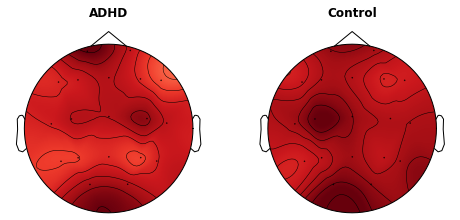

In [ ]:
indices = [ i for i in range(19)]

fig, ax = plt.subplots(ncols=2, figsize=(8, 8), gridspec_kw=dict(top=5),
                       sharex=True, sharey=True)

mne.viz.plot_topomap(minvalue_adhd, fake_evoked.info, axes=ax[0],
                     show=False)
mne.viz.plot_topomap(minvalue_control, fake_evoked.info, axes=ax[1],
                     show=False)

# add titles
ax[0].set_title('ADHD', fontweight='bold');
ax[1].set_title('Control', fontweight='bold');

**Inferences:**



A topographic map shows the spatial distribution of activity. 
The figure above shows the topographic map of a child diagnosed with ADHD and a normal child. A topographic map shows us the view of a person's scalp, where the circle is the person's head viewed from above. The black dots on the circle correspond to the approximate physical locations of each electrode. In this experiment 19 electrodes sampling at 128Hz were used to obtain the EEG recordings. In these type of topographic maps we assume that voltage value changes smoothly from one electrode to the next electrode (i.e. interpolation). From the above graphs the following conclusions can be made: 
1. There was a visual stimulus that was shown on the computer screen (the children were asked to count the number of characters from a given image and once the task was completed they were showed the next image) this is why we see an activity in the posterior regions corresponding to the activaion of the visual coretx region. Here we can see the visual cortex region of both ADHD and normal children were activated.
2. In a normal(control) child we can see the left side of the head (central lateral sensory motor area) lighting up. This indicates the child is responding to the visual stimulus. However for a child with ADHD, this region doesn't seem to light up. This is because of visual attention is one of the defecits in ADHD children, therefore they are slower to respond to visual stimulus in comparison to normal children.

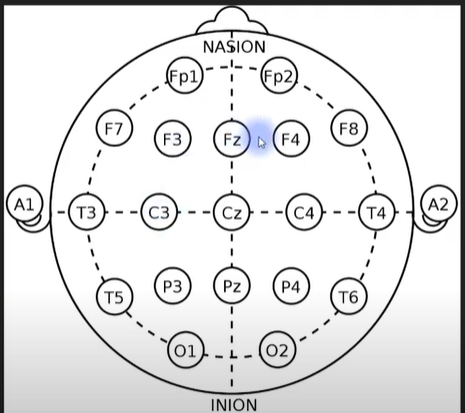

The electrodes are generally distributed in the manner shown above

## Modelling:

First we check if the data is linearly sepearable and then we continue to build the models

### **Is the data linearly separable?**

#### **Principal Component Analysis (PCA) - Dimensionality reduction** 

 - PCA is a dimension redcuction methodology which aims to reduce a large set of (often correlated) variables into a smaller set of (uncorrelated) variables, called principal components, which holds sufficient information without loosing the the relevant info much.

 - Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components.

In [ ]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(EEG_data)

principal_df = pd.DataFrame(data = principalComponents, columns=['principal_component_1', 'principal_component_2'])
reduced_df = pd.concat([principal_df, EEG_data[['Class']]], axis = 1)
reduced_df

,principal_component_1,principal_component_2,Class
0,0.544747,-0.216270,0
1,-0.080630,-0.720863,0
2,0.259782,-0.449260,0
3,-0.726897,0.066352,1
4,0.198177,-0.507275,0
...,...,...,...
116,0.172704,-0.534749,0
117,0.271292,0.804803,1
118,0.433625,-0.302016,0
119,-0.408721,0.332688,1


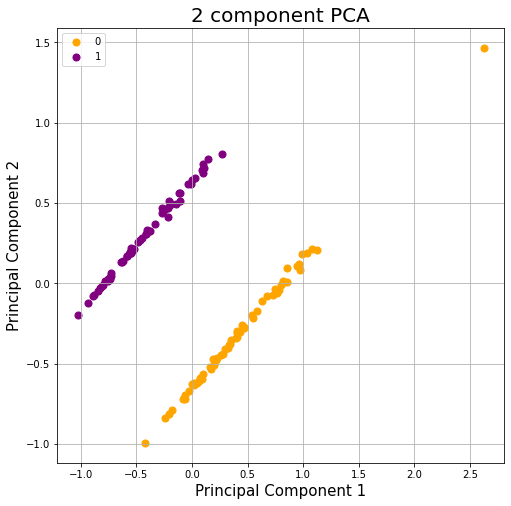

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['orange', 'purple']
for target, color in zip(targets,colors):
    indicesToKeep = reduced_df['Class'] == target
    ax.scatter(reduced_df.loc[indicesToKeep, 'principal_component_1'], 
               reduced_df.loc[indicesToKeep, 'principal_component_2'],
               c = color, 
               s = 50)
ax.legend(targets)
ax.grid()

From the above plot we can easily draw a straight line to separate the 2 classes, therefore we can conclude that the data is ***linearly seperable*** :) 


<Figure size 432x288 with 0 Axes>

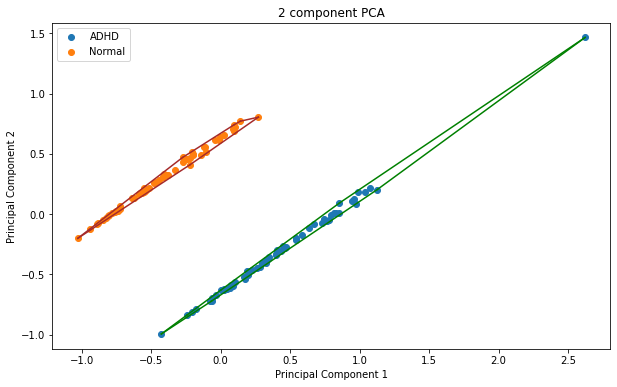

In [ ]:
plt.clf()
plt.figure(figsize = (10, 6))
names = ["ADHD", "Normal"]
label = [1, 0]
colors = ['green','brown']
plt.title('2 component PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i in range(len(names)):
    bucket = reduced_df[reduced_df['Class'] == i]
    bucket = bucket.iloc[:,[0,1]].values
    hull = ConvexHull(bucket)
    plt.scatter(bucket[:, 0], bucket[:, 1], label=names[i]) 
    for j in hull.simplices:
        plt.plot(bucket[j,0], bucket[j,1], colors[i])
plt.legend()
plt.show()

The convex hull represents the outer boundaries of a group of data points (classes). 
The logic when using convex hulls when testing for linear separability is: 
Two classes X and Y are linearly separable if the intersection of the convex hulls of X and Y is empty, and not linearly separable with a non-empty intersection.

The various modelling experiments in this notebook:

**Supervised approach:**
1. Perceptron for classification
2. Logistic Regression
3. KNN classification
4. Naive Bayes
5. Decision trees
6. Random forests
7. SVM

**Unsupervised approach:**
1. PCA - Dimensionality Reduction (Finding optimum parameters)
2. K means <br>
(Implemented along with Hyperparameter tuning - GridSearch and cross validation)


Grid Search uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters.

**In GridSearchCV, along with Grid Search, cross-validation is also performed.** Cross-Validation is used while training the model. In cross-validation, the process divides the train data further into 3 parts – the train data, test data and the validation data.

The most popular type of Cross-validation is K-fold Cross-Validation. It is an iterative process that divides the train data into k partitions. Each iteration keeps one partition for testing and the remaining k-1 partitions for training the model. The next iteration will set the next partition as test data and the remaining k-1 as train data and so on. In each iteration, it will record the performance of the model and at the end give the average of all the performance.

### **Supervised Approach:**

In [ ]:
predictions = []

#### **1. Perceptron for Classification**

In [ ]:
perceptron_data = EEG_data[columns]
perceptron_labels = EEG_data['Class']

In [ ]:
X_train_per, X_test_per, y_train_per, y_test_per = train_test_split(perceptron_data, perceptron_labels, test_size=0.3)

In [ ]:
print(" Perceptron \n")

print("Grid Search for alpha and n_iter")
perceptron = Perceptron(random_state=0)
gridsearch = GridSearchCV(perceptron, {'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
												               'n_iter_no_change': [5, 10, 15, 20, 50]},
									                      cv=5, # cross-validation
                                        scoring='accuracy')
gridsearch.fit(X_train_per, y_train_per)

print(f"Best params: {gridsearch.best_params_}")
print(f"Best accuracy score: {gridsearch.best_score_}")

 Perceptron 

Grid Search for alpha and n_iter
Best params: {'alpha': 0.0001, 'n_iter_no_change': 50}
Best accuracy score: 0.6794117647058824


In [ ]:
# Model with best parameters obtained after GridSearchCV
perceptron = Perceptron(alpha=0.0001, n_iter_no_change=15)
scores = cross_val_score(perceptron, X_train_per, y_train_per, scoring='accuracy', cv=5)
print(f"Cross-validation (mean) accuracy-score: {np.mean(scores)}\n")

perceptron.fit(X_train_per, y_train_per)
predicted_per = perceptron.predict(X_test_per)


Cross-validation (mean) accuracy-score: 0.5



In [ ]:
print(f"intercept: {perceptron.intercept_}")
print(f"coefs: {perceptron.coef_}")

intercept: [-1.]
coefs: [[-19.6507866   -5.13870391  16.69574235   2.66184051   7.60901926
    0.19297231   3.20631733   9.35713234 -14.96903298  -2.31349252
   -7.56765538  -1.35104836  -5.98352102  -5.22594459  -6.81002624
   -5.3423642   18.09559994   3.05553258   5.28721396]]


In [ ]:
predictions.append([predicted_per, y_test_per])

#### **2. Logistic Regression**

In [ ]:
data = EEG_data[columns]
labels = EEG_data['Class']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(data, labels, test_size=0.3)

In [ ]:
gridsearch_log = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]} # l1 lasso l2 ridge

logreg = LogisticRegression()

logreg_cv = GridSearchCV(logreg, gridsearch_log, cv=10)   # cv - stands for cross validation (Stratified K-Fold) here K=10

logreg_cv.fit(X_train_log, y_train_log)

print("Tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("Accuracy :",logreg_cv.best_score_)

Tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
Accuracy : 0.7152777777777778


In [ ]:
# Model with best parameters obtained after GridSearchCV
logreg2 = LogisticRegression(C=10, penalty="l2")

logreg2.fit(X_train_log, y_train_log)

print("Score: ", logreg2.score(X_test_log, y_test_log))

Score:  0.7027027027027027


In [ ]:
prediction_log = logreg2.predict(X_test_log)
predictions.append([prediction_log, y_test_log])

#### **3. KNN Classification**

In [ ]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(data, labels, test_size=0.3)

In [ ]:
gridsearch_knn = {
    'n_neighbors': [3,  5, 11, 19, 21, 23, 25, 27],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = GridSearchCV(KNeighborsClassifier(),
                   gridsearch_knn,
                   verbose=1, 
                   cv=3, # Does stratifiedKFold cross validation
                   n_jobs=-1)

knn_result = knn.fit(X_train_knn, y_train_knn)
print("\n", knn_result.best_score_, "\n")
print(knn_result.best_estimator_, "\n")
print(knn_result.best_params_, "\n")

Fitting 3 folds for each of 32 candidates, totalling 96 fits

 0.6428571428571429 

KNeighborsClassifier(metric='euclidean', n_neighbors=27, weights='distance') 

{'metric': 'euclidean', 'n_neighbors': 27, 'weights': 'distance'} 



In [ ]:
# Model with best parameters obtained after GridSearchCV
knn_model = KNeighborsClassifier(**knn_result.best_params_)
knn_model.fit(X_train_knn, y_train_knn)
knn_predictions = knn_model.predict(X_test_knn)
print("Score: ", knn_model.score(X_test_knn, y_test_knn))

Score:  0.6216216216216216


In [ ]:
predictions.append([knn_predictions, y_test_knn])

#### **4. Naive Bayes**

In [ ]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(EEG_data[columns], EEG_data['Class'], test_size=0.3)

In [ ]:
gridsearch_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=gridsearch_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train_nb, y_train_nb)

print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=1.0)


In [ ]:
# Model with best parameters obtained after GridSearchCV
nb_model = GaussianNB(**nbModel_grid.best_params_)
nb_model.fit(X_train_nb, y_train_nb)
nb_predictions = nb_model.predict(X_test_nb)
print("Score: ", nb_model.score(X_test_nb, y_test_nb))

Score:  0.5945945945945946


In [ ]:
predictions.append([nb_predictions, y_test_nb])

#### **5. Decision Trees**

In [ ]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(data, labels, test_size=0.3)

In [ ]:
gridsearch_dt = {'max_leaf_nodes': list(range(2, 50)), 
                  'min_samples_split': [2, 3, 4, 5]}

dt = GridSearchCV(DecisionTreeClassifier(), 
                  gridsearch_dt , 
                  verbose=1, 
                  cv=5)

dt_result = dt.fit(X_train_dt, y_train_dt)

print("\n", dt_result.best_score_, "\n")
print(dt_result.best_estimator_, "\n")
print(dt_result.best_params_, "\n")

Fitting 5 folds for each of 192 candidates, totalling 960 fits

 0.8338235294117646 

DecisionTreeClassifier(max_leaf_nodes=22) 

{'max_leaf_nodes': 22, 'min_samples_split': 2} 



In [ ]:
# Model with best parameters obtained after GridSearchCV
dt_model = DecisionTreeClassifier(**dt_result.best_params_)
dt_model.fit(X_train_dt, y_train_dt)
dt_predictions = dt_model.predict(X_test_dt)

In [ ]:
print("Score: ", dt_model.score(X_test_dt, y_test_dt))

Score:  0.5405405405405406


In [ ]:
predictions.append([dt_predictions, y_test_dt])

#### **6. Random Forests**

In [ ]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(data, labels, test_size=0.3)

In [ ]:
# Hyper-parameter optimisation using GridSearchCV
gridsearch_rf = { 'n_estimators': [100,150, 200],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth' : [4,6,8,12,14,16],
                  'criterion' :['gini', 'entropy'],
                  'n_jobs':[-1]
                  }

#Fitting the trainingset to find parameters with best accuracy
rf = GridSearchCV(estimator=RandomForestClassifier(), 
                     param_grid=gridsearch_rf, 
                     cv= 3)
                            
rf_result = rf.fit(X_train_rf, y_train_rf)
print("\n", rf_result.best_score_, "\n")
print(rf_result.best_estimator_, "\n")
print(rf_result.best_params_, "\n")


 0.7619047619047619 

RandomForestClassifier(criterion='entropy', max_depth=16, max_features='sqrt',
                       n_jobs=-1) 

{'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1} 



In [ ]:
# Model with best parameters obtained after GridSearchCV
rf_model = RandomForestClassifier(**rf_result.best_params_)
rf_model.fit(X_train_rf, y_train_rf)
rf_predictions = rf_model.predict(X_test_rf)

In [ ]:
print("Score: ", rf_model.score(X_test_rf, y_test_rf))

Score:  0.5945945945945946


In [ ]:
predictions.append([rf_predictions, y_test_rf])

#### **7. SVM**

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(data, labels, test_size=0.3)

In [ ]:
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
}

model_svc = SVC(class_weight="balanced",
                probability=True,)

model_svc = GridSearchCV(model_svc, 
                         parameters, 
                         cv=5,
                         scoring='accuracy')

model_svc.fit(X_train_svm, y_train_svm)

print(f'Best parameters {model_svc.best_params_}')
print(f'Mean cross-validated accuracy score of the best_estimator: ' +  f'{model_svc.best_score_:.3f}')

Best parameters {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Mean cross-validated accuracy score of the best_estimator: 0.669


In [ ]:
# Model with best parameters obtained after GridSearchCV
svm_model = SVC(**model_svc.best_params_)
svm_model.fit(X_train_svm, y_train_svm)
svm_predictions = svm_model.predict(X_test_svm)

In [ ]:
print("Score: ", svm_model.score(X_test_svm, y_test_svm))

Score:  0.7837837837837838


In [ ]:
predictions.append([svm_predictions, y_test_svm])

### **Unsupervised approach:**

#### **1. PCA (Dimensionality Reduction)**

In [ ]:
X = EEG_data[columns]
Y = EEG_data['Class']

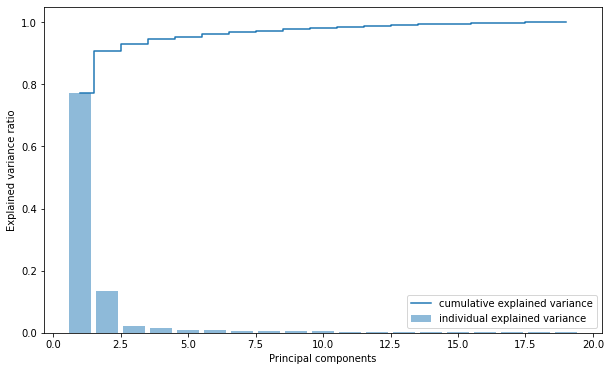

In [ ]:
# Calculating covariance matrix
cov_matrix = np.cov(X.T)
#print("cov_matrix shape:",cov_matrix.shape)
#print("Covariance_matrix",cov_matrix)

# Calculating Eigen Vectors and Eigen Values
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
#print('Eigen Vectors \n%s', eigenvectors)
#print('\n Eigen Values \n%s', eigenvalues)

# Make a set of (eigenvalue, eigenvector) pairs
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
eig_pairs.sort()

eig_pairs.reverse()
#print(eig_pairs)

# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]

#print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)] 
cum_var_exp = np.cumsum(var_explained) 

plt.figure(figsize = (10, 6))
plt.bar(range(1,20), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 20),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

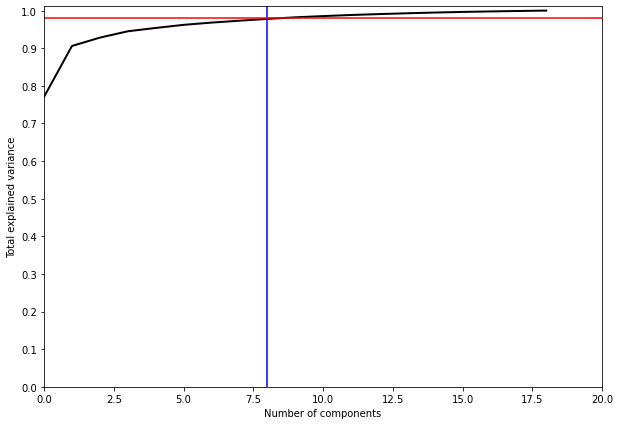

In [ ]:
pca = PCA().fit(EEG_data[columns])

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 20)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(8, c='b')
plt.axhline(0.98, c='r')
plt.show();

We can see that 8 dimensions are able to explain 98 %variance of data. Therefore the optimum number of dimensions to explain the data is 8

In [ ]:
pca = PCA(n_components=8)
pca.fit(X)
transformed_data = pca.transform(X)
transformed_data = pd.DataFrame(transformed_data)
transformed_data

,0,1,2,3,4,5,6,7
0,0.290807,0.029615,-0.166719,0.035281,-0.007171,0.028714,-0.086541,-0.025974
1,-0.511962,-0.058220,-0.132909,-0.016711,0.011811,-0.019555,0.000478,0.010599
2,-0.075960,-0.128549,-0.148499,0.102536,-0.000475,-0.024022,-0.005377,0.017624
3,-0.528456,0.103499,0.037467,0.080047,-0.067662,-0.001044,0.043185,0.006911
4,-0.158252,-0.252616,-0.060074,0.009444,-0.015381,-0.062699,0.009878,-0.010174
...,...,...,...,...,...,...,...,...
116,-0.194297,-0.115740,-0.061877,-0.211964,0.113749,-0.097704,0.038871,-0.055237
117,0.726734,-0.562858,-0.075889,0.002642,0.023364,-0.003365,0.016548,0.028634
118,0.149773,0.032702,-0.015308,-0.140025,0.010182,0.096612,0.056108,-0.069401
119,-0.116203,0.237488,0.168049,-0.010432,0.018679,0.017999,-0.056623,0.052717


Reduced datasets

#### **2. K-Means Clustering**

K-Means on reduced dimension dataset

In [ ]:
X_train_k_pc, X_test_k_pc, y_train_k_pc, y_test_k_pc = train_test_split(transformed_data, Y, test_size=0.3)

In [ ]:
# Finding optimal number of clusters using Elbow method
kmeans_params = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 42}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_params)
  kmeans.fit(X_train_k_pc)
  sse.append(kmeans.inertia_)

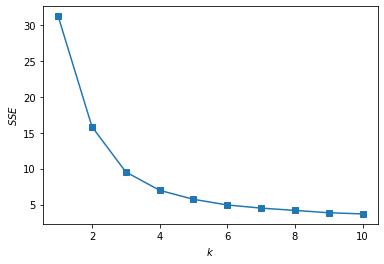

In [ ]:
plt.plot(range(1, 11), sse, marker='s');
plt.xlabel('$k$')
plt.ylabel('$SSE$');

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(X_test_k_pc)
kmeans_labels_pca = kmeans.labels_

In [ ]:
(kmeans_labels_pca == y_test_k_pc).sum() / len(kmeans_labels_pca)

0.5405405405405406

K-Means on dataset that hasn't been reduced to 8 dimensions

In [ ]:
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(EEG_data[columns], EEG_data['Class'], test_size=0.3)

In [ ]:
# Finding optimal number of clusters using Elbow method
kmeans_params = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 42}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_params)
  kmeans.fit(X_train_k)
  sse.append(kmeans.inertia_)

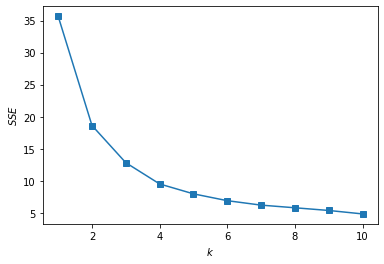

In [ ]:
plt.plot(range(1, 11), sse, marker='s');
plt.xlabel('$k$')
plt.ylabel('$SSE$');

We see that SSE decreases significantly until the number of clusters is 2 and then does not change as much anymore. This means that the optimal number of clusters is 2.

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(X_test_k)
kmeans_labels = kmeans.labels_

In [ ]:
(kmeans_labels == y_test_k).sum() / len(kmeans_labels)

0.3783783783783784

In [ ]:
predictions.append([kmeans_labels_pca, y_test_k_pc])

## Evaluation Metrics:


In [ ]:
def evaluate_results(predictions, y_test, classifier_name):
  """
  This is a function that calculates and prints the evaluation metrics.

  Arguments: 
  predictions - predictions of the model
  y_test - true values
  classifier_name - algorithm used to classify the model
  """
  accuracy = accuracy_score(y_test, predictions)
  f1_scores = f1_score(y_test, predictions, average='micro')
  precision = precision_score(y_test, predictions, average="weighted")
  recall = recall_score(y_test, predictions, average="weighted")
 
  print("-------------------------------------------------------------------")
  print(f"    \t{classifier_name} CLASSIFIER RESULTS   ")
  print("Accuracy  :", accuracy)
  print("F1 Score  : ", f1_scores)
  print("Precision  :", precision)
  print("Recall  : ", recall)
  print(f"\n\t\tCLASSIFICATION REPORT OF {classifier_name} CLASSIFIER")
  print(" ")
  print(classification_report(y_test, predictions))
  print("-------------------------------------------------------------------")
  return accuracy 

In [ ]:
def plot_confusion_matrix(y_test, predictions, classifier_name):
  # Confusion matrix
  print(f"    \t{classifier_name} CLASSIFIER RESULTS   ")
  ax= plt.subplot()
  sns.heatmap(confusion_matrix(y_test, predictions), annot=True, ax = ax, cmap = "BuPu");
  # labels, title and ticks
  ax.set_xlabel("Predicted labels")
  ax.set_ylabel("True labels")
  ax.set_title("Confusion Matrix")
  ax.xaxis.set_ticklabels(["Control", "ADHD"])
  ax.yaxis.set_ticklabels(["Control", "ADHD"])

In [ ]:
models = ["Perceptron", "Logistic Regression", "KNN", "Naive Bayes", "Decision trees", "Random Forests", "SVM", "K-Means"]
accuracies = []
for i in range(len(models)):
  accuracies.append(evaluate_results(predictions[i][0], predictions[i][1], models[i]))

-------------------------------------------------------------------
    	Perceptron CLASSIFIER RESULTS   
Accuracy  : 0.4594594594594595
F1 Score  :  0.4594594594594595
Precision  : 0.7597597597597597
Recall  :  0.4594594594594595

		CLASSIFICATION REPORT OF Perceptron CLASSIFIER
 
              precision    recall  f1-score   support

           0       0.44      1.00      0.62        16
           1       1.00      0.05      0.09        21

    accuracy                           0.46        37
   macro avg       0.72      0.52      0.35        37
weighted avg       0.76      0.46      0.32        37

-------------------------------------------------------------------
-------------------------------------------------------------------
    	Logistic Regression CLASSIFIER RESULTS   
Accuracy  : 0.7027027027027027
F1 Score  :  0.7027027027027027
Precision  : 0.7853430353430354
Recall  :  0.7027027027027027

		CLASSIFICATION REPORT OF Logistic Regression CLASSIFIER
 
              precisi

    	Perceptron CLASSIFIER RESULTS   


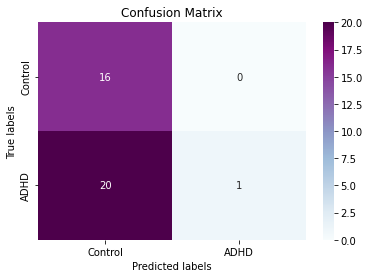

In [ ]:
plot_confusion_matrix(predictions[0][1], predictions[0][0], models[0])

    	Logistic Regression CLASSIFIER RESULTS   


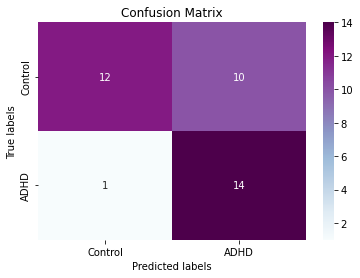

In [ ]:
plot_confusion_matrix(predictions[1][1], predictions[1][0], models[1])

    	KNN CLASSIFIER RESULTS   


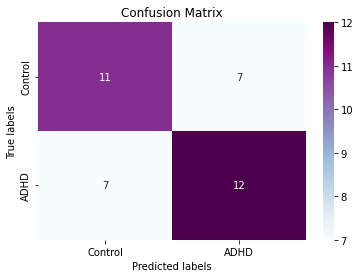

In [ ]:
plot_confusion_matrix(predictions[2][1], predictions[2][0], models[2])

    	Naive Bayes CLASSIFIER RESULTS   


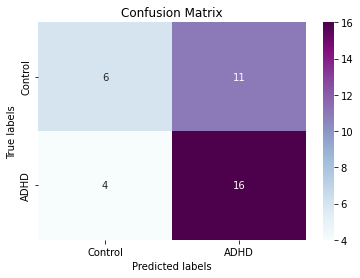

In [ ]:
plot_confusion_matrix(predictions[3][1], predictions[3][0], models[3])

    	Decision trees CLASSIFIER RESULTS   


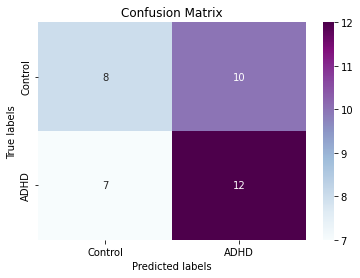

In [ ]:
plot_confusion_matrix(predictions[4][1], predictions[4][0], models[4])

    	Random Forests CLASSIFIER RESULTS   


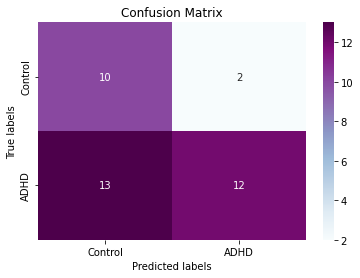

In [ ]:
plot_confusion_matrix(predictions[5][1], predictions[5][0], models[5])

    	SVM CLASSIFIER RESULTS   


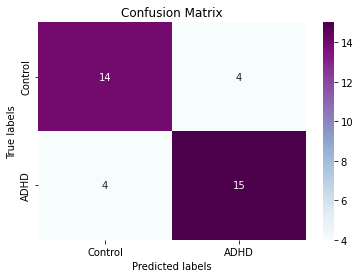

In [ ]:
plot_confusion_matrix(predictions[6][1], predictions[6][0], models[6])

    	K-Means CLASSIFIER RESULTS   


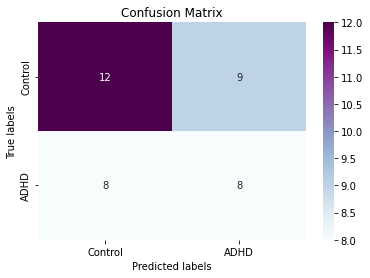

In [ ]:
plot_confusion_matrix(np.array(predictions[7][1]), predictions[7][0], models[7])

-----------------------------------------------------------------------------------------------

Model: Perceptron

ROC_AUC score: 0.5238095238095238


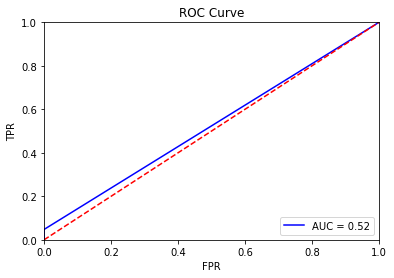

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: Logistic Regression

ROC_AUC score: 0.7393939393939394


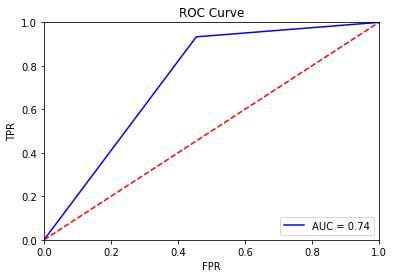

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: KNN

ROC_AUC score: 0.6213450292397661


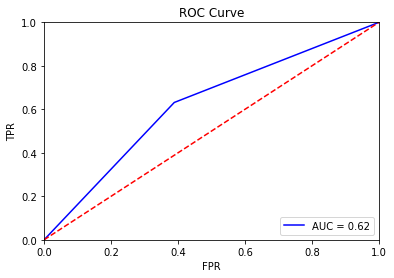

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: Naive Bayes

ROC_AUC score: 0.5764705882352941


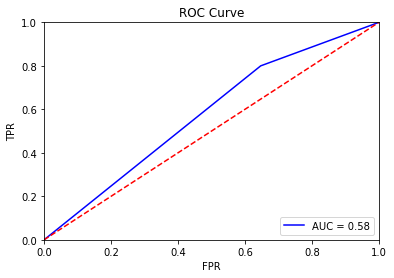

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: Decision trees

ROC_AUC score: 0.5380116959064327


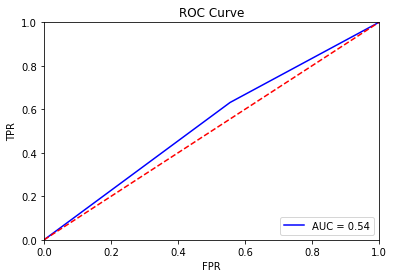

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: Random Forests

ROC_AUC score: 0.6566666666666667


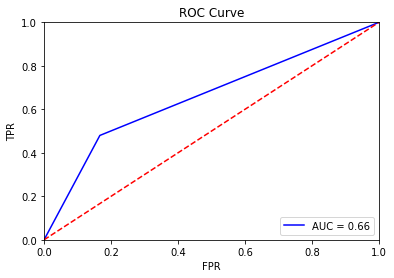

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: SVM

ROC_AUC score: 0.7836257309941521


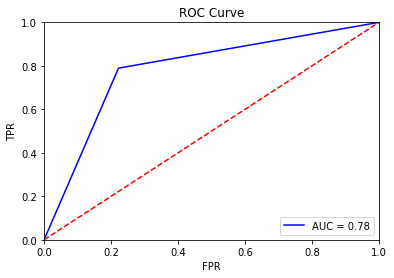

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

Model: K-Means

ROC_AUC score: 0.5357142857142857


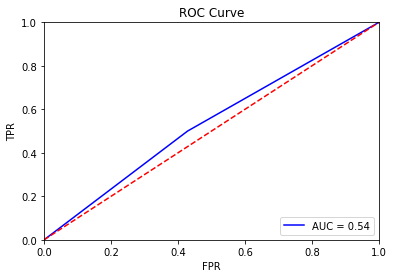

-----------------------------------------------------------------------------------------------


In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
for i in range(len(predictions)):
  pred = predictions[i][0]
  test = predictions[i][1]
  fpr, tpr, thresholds = roc_curve(test, pred)
  roc_auc = roc_auc_score(test, pred)
  print("-----------------------------------------------------------------------------------------------")
  print(f"\nModel: {models[i]}\n")
  print(f"ROC_AUC score: {roc_auc}")  
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.title("ROC Curve")
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('TPR')
  plt.xlabel('FPR')
  plt.show();
  print("-----------------------------------------------------------------------------------------------")
  

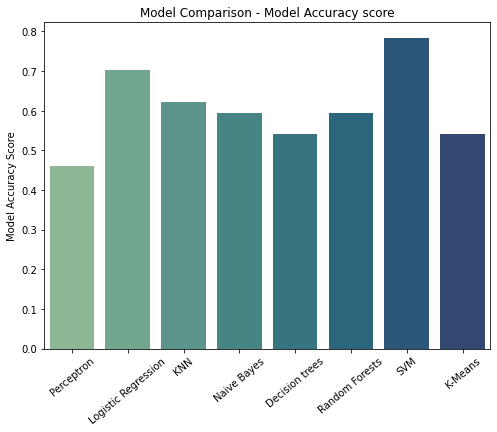

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=models,y=accuracies, palette="crest");
plt.ylabel("Model Accuracy Score")
plt.xticks(rotation=40)
plt.title("Model Comparison - Model Accuracy score");

Best performing models (based on accuracies)
1. SVM
2. Logistic Regression
3. KNN
4. Naive Bayes
5. Random Forests
6. K-Means, Decision trees
7. Perceptron

After analysing all the metrics we can conclude SVM is the best performing model.
The ranking of the models taking all metrics into consideration: 
1. SVM
2. Logistic Regression
3. KNN
4. Random Forests
5. Naive Bayes
6. K-Means, Decision trees
7. Perceptron

--------------------------------------------------------------------------------------------------------------------